#RBM

In [1]:
"""
TO DO:

1. Implement Gibbs sampling by completing the functions
   - sample_prob
   - sample_h_given_v
   - sample_v_given_h
   - gibbs_hvh
   - gibbs_vhv

2. Perform the weight updates in the function "get_cost_updates"

By executing this file you can test if your function produce sensible output!

---------------------------------------------------------------
--------------------------------------------------------------

Useful commands:

math-operations:
tf.matmul
tf.random_uniform
tf.shape
tf.sign

activation functions:
tf.nn.relu, tf.nn.sigmoid

udating variables:
a.assign_add(b) -> value of variable a is updated by adding output value of b

"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
# import dlipr
from keras.datasets import mnist

class RBM(object):
    """ Restricted Boltzmann Machine (RBM) """
    
    def __init__(self, X_train=None, X_test=None, n_visible=28*28, n_hidden=100, W=None, hbias=None, vbias=None):

        self.X_train = X_train
        self.X_test = X_test
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        X = tf.placeholder("float", [None, n_visible])
        
        # initialize weights and biases

        # weight matrix
        if W is None:
            W = tf.Variable(tf.random_uniform([n_visible, n_hidden],
                minval=-4 * tf.sqrt(6. / (n_hidden + n_visible)),
                maxval=4 * tf.sqrt(6. / (n_hidden + n_visible))))
        # bias vector of hidden units
        if hbias is None:
            hbias = tf.Variable(tf.zeros([n_hidden]))
        # bias vector of visible units
        if vbias is None:
            vbias = tf.Variable(tf.zeros([n_visible]))
        
        self.X = X
        self.W = W
        self.hbias = hbias
        self.vbias = vbias
        self.w_upd8 = None
        self.hbias_upd8 = None
        self.vbias_upd8 = None
        self.cost = None

    # sample binary units from real-valued probabilities: v_i/h_j = 1 if p_{i/j} > rand()      
    def sample_prob(self,probs):
        # input: probabilities "probs" of visible or hidden units
        # output: matrix with binary units of same size as probs (v_i/h_j = 1 if probs > rand())
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))
    
    # calculate hidden units from visible units
    def sample_h_given_v(self, vis):
        # input: visible units
        # output: h_mean (probabilities of hidden units)
        #         h_sample (hidden binary units)
        
        h_mean = tf.nn.sigmoid(tf.matmul(vis, self.W) + self.hbias)
        h_sample = self.sample_prob(h_mean)
        return (h_mean, h_sample)        
    
    # reconstruct visible units from hidden units
    def sample_v_given_h(self, hid):
        # input: hidden units
        # output: v_mean (probabilities of visible units)
        #         v_sample (visible binary units)
        v_mean = tf.nn.sigmoid(tf.matmul(hid, tf.transpose(self.W)) + self.vbias)
        v_sample = self.sample_prob(v_mean)
        return (v_mean, v_sample)        

    # Gibbs sampling step: begin with hidden units
    def gibbs_hvh(self, h0_sample):
        # calculate visible units v1_mean, v1_sample from hidden units h0_sample
        # calculate hidden units h1_mean, h1_sample from visible units v1_sample
        v1_mean, v1_sample = self.sample_v_given_h(h0_sample)
        h1_mean, h1_sample = self.sample_h_given_v(v1_sample)
        return (v1_mean, v1_sample, h1_mean, h1_sample)        

    # Gibbs sampling step: begin with visible units    
    def gibbs_vhv(self, v0_sample):
        # calculate hidden units h0_mean, h0_sample from visible units v0_sample
        # calculate from units v1_mean, v1_sample from hidden units h0_sample
        h1_mean, h1_sample = self.sample_h_given_v(v0_sample)
        v1_mean, v1_sample = self.sample_v_given_h(h1_sample)
        return (h1_mean, h1_sample, v1_mean, v1_sample)        


# -----------------------------------------------------------
#   set up model
# -----------------------------------------------------------

    def get_cost_updates(self, lr=0.1, k=1):
        
        # positive phase: calculate hidden units from input data
        ph_means, ph_samples = self.sample_h_given_v(self.X)

        # Constrastive divergence: CD_k
        # negative phase: alternating calculation of visible (real-valued) and 
        #                 hidden units (stochastic binary states) 
        for step in range(k):
            if step == 0:
                nv_means, nv_samples, nh_means, nh_samples = self.gibbs_hvh(ph_samples)
            else:
                nv_means, nv_samples, nh_means, nh_samples = self.gibbs_hvh(nh_samples)
        
        # calculate variable updates
        """
        Take a similar approach for updating the weights as it is shown here for the biases
        - For x_0 and h_0 use self.X and ph_samples
        - For x_k and h_k use nv_samples and nh_means 
          (take probabilities of final hidden units nh_means to avoid unnecessary sampling noise)
        """
        self.w_upd8 = self.W.assign_add(lr * (tf.matmul(tf.transpose(self.X), ph_means) - 
                                        tf.matmul(tf.transpose(nv_samples), nh_means)) / tf.to_float(tf.shape(self.X)[0]))
        self.vbias_upd8 = self.vbias.assign_add(lr * tf.reduce_mean(self.X - nv_samples, 0))
        self.hbias_upd8 = self.hbias.assign_add(lr * tf.reduce_mean(ph_samples - nh_means, 0))

        # objective function: binary crossentropy
        monitoring_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X, logits=nv_samples))
        
        self.cost = monitoring_cost
        
        return monitoring_cost
    
    
# -----------------------------------------------------------
#       training loop
# -----------------------------------------------------------

    def training(self, lr=0.1, k=1, n_epoch=3, batch_size=32):
        
        cost = []
        saver = tf.train.Saver()

        # set up graph
        self.get_cost_updates(lr=lr, k=k)

        with tf.Session() as sess:
            
            sess.run(tf.global_variables_initializer())

            for epoch in range(n_epoch):
                # number of updates per epoch
                n_updates = len(self.X_train)//batch_size   
                # shuffle training set
                perm = np.random.choice(len(self.X_train), size=len(self.X_train), replace='False')  
                
                for i in range(n_updates):
                    # training batch
                    batch = self.X_train[perm[i*batch_size:(i+1)*batch_size]]
                    # train on batch: update weights, biases and training loss
                    sess.run([self.w_upd8, self.hbias_upd8, self.vbias_upd8, self.cost], feed_dict={self.X: batch})
                
                # update validation loss
                cost.append(sess.run(self.cost, feed_dict={self.X: self.X_test}))

            # save final model, get weights and biases
            save_path = saver.save(sess, "./model.ckpt")
            W = sess.run(self.W)
            hbias = sess.run(self.hbias)
            vbias = sess.run(self.vbias)
            
        return W, hbias, vbias, cost
    
# -----------------------------------------------------------   
#   Set up generating model
# -----------------------------------------------------------

    def daydream(self, k=50):
        
        for step in range(k):
            
            if step == 0:
                nh_means, nh_samples, nv_means, nv_samples = self.gibbs_vhv(self.X)
            else:
                # for better stability of reconstruction use probabilities for visible units
                # during image generation phase
                nh_means, nh_samples, nv_means, nv_samples = self.gibbs_vhv(nv_means)
                
        return nv_means, nv_samples
 
# -----------------------------------------------------------   
#   Generate new samples from input data
# -----------------------------------------------------------
   
    def images(self, inputdata=None, k=50):
        
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(os.path.dirname(os.path.abspath('/content/checkpoint/')))
        with tf.Session() as sess:
            # load model
            saver.restore(sess, ckpt.model_checkpoint_path)
            W = self.W.eval()
            # set up graph
            nv_means, nv_samples = self.daydream(k=k)
            # generate new images by performing alternating Gibbs sampling for many steps
            vis_mean, vis_samples = sess.run([nv_means,nv_samples], feed_dict={self.X: inputdata})
            
        return vis_mean, vis_samples




# -----------------------------------------------------------   
#   Test of Task 1
# -----------------------------------------------------------

if __name__ == '__main__':
    
    """
    Task 1.1: Implement Gibbs sampling
    """
    
    (train_images, y_train), (test_images, y_test) = mnist.load_data()
    X_test = test_images.reshape(-1, 28**2).astype('float32')/255
    X_test_image = X_test[0:2]
    X_test[X_test>0.5] = 1.
    X_test[X_test<=0.5] = 0.
    
    rbm = RBM(X_train=X_test_image, X_test=X_test_image)
    
    """
    1. Test sample_prob
    """
    probs = tf.random_uniform([1, 32], minval=0., maxval=1.)
    sample_binary = rbm.sample_prob(probs)
    
    with tf.Session() as sess:
        print('================= \n 1. sample_prob \n=================')
        print('Probabily vector: \n' + str(sess.run(probs)) + '\n')
        print('Binary units: \n' + str(sess.run(sample_binary)))
    
    """
    2./3. Test sample_h_given_v and sample_v_given_h with first two images of the test set
    """
    h_mean, h_sample = rbm.sample_h_given_v(X_test_image)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('================= \n 2. sample_h_given_v \n=================')
        # only hidden units of first image are printed
        print('Probabily h_mean: \n' + str(sess.run(h_mean[0])) + '\n')      
        print('Binary units h_sample: \n' + str(sess.run(h_sample[0])) + '\n')
        print('shape(h_sample)/shape(h_mean): ' + str(sess.run(tf.shape(h_sample))) + '\n\n')
    
    v_mean, v_sample = rbm.sample_v_given_h(h_sample)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('================= \n 3. sample_h_given_v \n=================')
        print('Probabily v_mean: \n' + str(sess.run(v_mean)) + '\n')
        print('Binary units v_sample: \n' + str(sess.run(v_sample)) + '\n')
        print('shape(v_sample)/shape(v_mean): ' + str(sess.run(tf.shape(v_sample))) + '\n\n')
        
    """
    4./5. Test gibbs_vhv and gibbs_hvh with first image of the test set
    """
    h0_mean, h0_sample, v1_mean, v1_sample = rbm.gibbs_vhv(X_test_image)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('================= \n 4. gibbs_vhv \n=================')
        print('shape(h0_sample)/shape(h0_mean): ' + str(sess.run(tf.shape(h0_sample))) + '\n')
        print('shape(v1_sample)/shape(v1_mean): ' + str(sess.run(tf.shape(v1_sample))) + '\n\n')
    
    v1_mean, v1_sample, h1_mean, h1_sample = rbm.gibbs_hvh(h0_sample)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('================= \n 5. gibbs_hvh \n=================')
        print('shape(v1_sample)/shape(v1_mean): ' + str(sess.run(tf.shape(v1_sample))) + '\n')
        print('shape(h1_sample)/shape(h1_mean): ' + str(sess.run(tf.shape(h1_sample))) + '\n\n')
            
    """
    Task 1.2 : Verify weight updates
    """    
    for i in range(2):
        W, hbias, vbias, cost = rbm.training(lr=0.001, k=1, n_epoch=1, batch_size=1)
        print(W)
        print(cost)

Using TensorFlow backend.


 1. sample_prob 
Probabily vector: 
[[0.19498587 0.4339931  0.1657778  0.378379   0.21726716 0.3863399
  0.7980174  0.75742877 0.6498593  0.89184976 0.28166127 0.94312537
  0.6696851  0.05075836 0.56428134 0.50670505 0.02948976 0.91212523
  0.38756442 0.69973385 0.8155006  0.7908325  0.04146302 0.7213099
  0.34250367 0.93848836 0.2992046  0.5552293  0.82840896 0.95387197
  0.9625236  0.6172999 ]]

Binary units: 
[[1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
  0. 1. 1. 0. 0. 1. 0. 0.]]
 2. sample_h_given_v 


W0701 05:55:09.993928 140336585496448 deprecation.py:323] From <ipython-input-1-b325b1215612>:144: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0701 05:55:10.006037 140336585496448 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Probabily h_mean: 
[0.11499104 0.58588946 0.5233146  0.477505   0.585634   0.6071191
 0.7422164  0.31799862 0.83803153 0.08498341 0.8469651  0.21623486
 0.8054967  0.31431368 0.92001927 0.6031613  0.2582186  0.5115672
 0.67186815 0.7627946  0.11067647 0.9562235  0.14122978 0.6204319
 0.16835037 0.0779644  0.4121071  0.38597867 0.08740151 0.70988375
 0.6342322  0.665147   0.05358776 0.7262833  0.8305793  0.32829085
 0.409746   0.9598128  0.5504662  0.5058914  0.33998743 0.20750415
 0.21144158 0.7585664  0.02280471 0.67813957 0.23930514 0.6705302
 0.5149405  0.60719544 0.40701202 0.2130734  0.90347844 0.22861663
 0.15715086 0.7057964  0.7274811  0.35363483 0.09149632 0.88665766
 0.2709664  0.32346892 0.7126284  0.15962505 0.3984153  0.62541413
 0.34945083 0.09222436 0.54595536 0.8839814  0.05189508 0.8416294
 0.12456623 0.20142025 0.5643392  0.65901905 0.37952948 0.19361973
 0.93129885 0.45442626 0.9116219  0.6003329  0.5132819  0.3697319
 0.1771133  0.96471584 0.23557004 0.11615637 0.59

#2

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


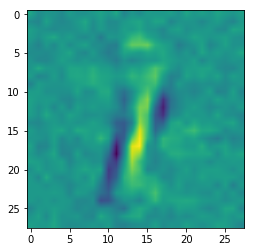

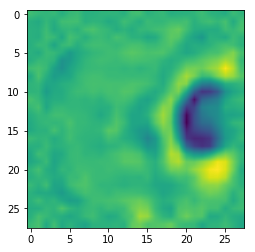

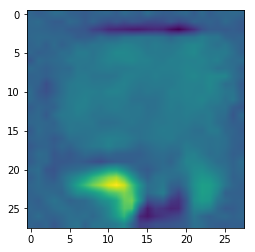

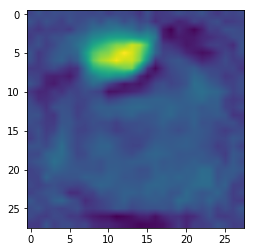

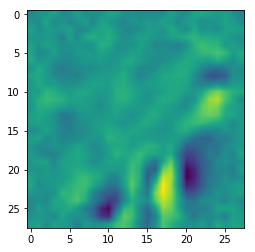

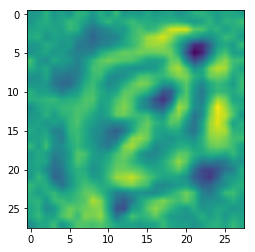

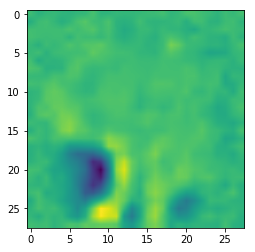

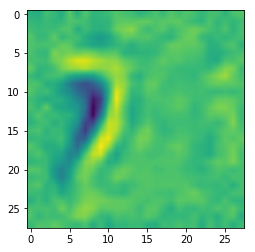

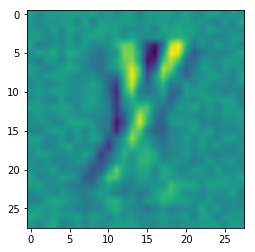

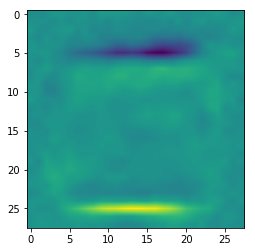

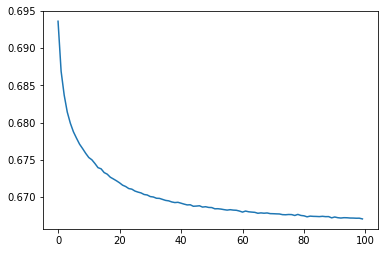

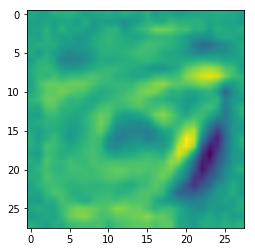

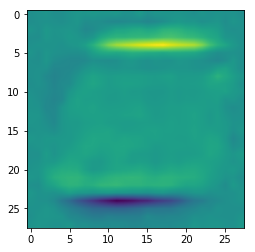

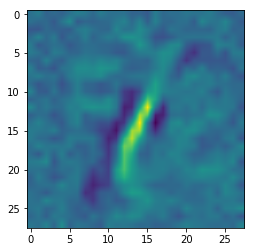

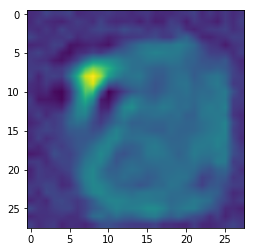

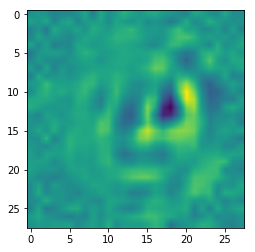

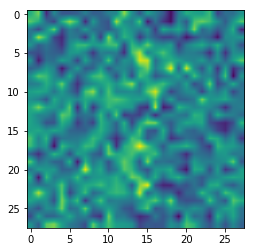

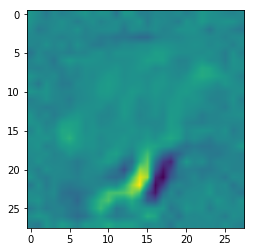

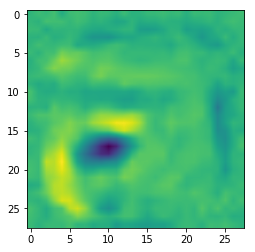

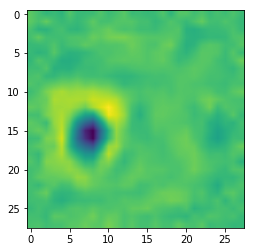

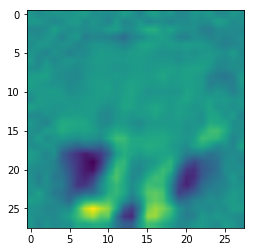

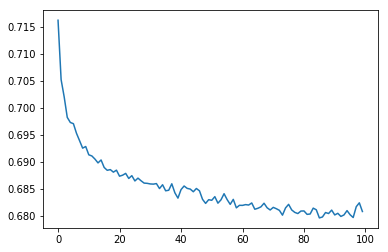

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from rbm import RBM
# import dlipr

# data = mnist.load_data()

X_train = train_images.reshape(-1, 28**2).astype('float32')/255
X_test = test_images.reshape(-1, 28**2).astype('float32')/255
# convert input to stochastic binary states
X_train[X_train>0.5] = 1.
X_train[X_train<=0.5] = 0.
X_test[X_test>0.5] = 1.
X_test[X_test<=0.5] = 0.

# rbm model
rbm = RBM(X_train=X_train, X_test=X_test, n_visible=28*28, n_hidden=100, W=None, hbias=None, vbias=None)

"""
TASK 2:

1. Train the given RBM with CD-1 and CD-10 for at least 50 epochs with a suitable learning rate.

2. Plot the weight matrices and the validation loss.

3. Sample from learned model, start Markov chain with 10 test samples showing digits from 0-9. 
   Draw images for every 100 steps of Gibbs sampling.
"""
  
   

probs = tf.random_uniform([1, 32], minval=0., maxval=1.)
sample_binary = rbm.sample_prob(probs)
h_mean, h_sample = rbm.sample_h_given_v(X_train)
v_mean, v_sample = rbm.sample_v_given_h(h_sample)
h0_mean, h0_sample, v1_mean, v1_sample = rbm.gibbs_vhv(X_train)
v1_mean, v1_sample, h1_mean, h1_sample = rbm.gibbs_hvh(h0_sample)

W, hbias, vbias, cost = rbm.training(lr=0.5, k=1, n_epoch=100, batch_size=512)
for i in range(10):
    plt.figure()
    plt.imshow(np.reshape(W[:,i],(28,28)), interpolation = 'bilinear')
cost = np.array(cost)
plt.figure()
plt.plot(cost)

probs = tf.random_uniform([1, 32], minval=0., maxval=1.)
sample_binary = rbm.sample_prob(probs)
h_mean, h_sample = rbm.sample_h_given_v(X_train)
v_mean, v_sample = rbm.sample_v_given_h(h_sample)
h0_mean, h0_sample, v1_mean, v1_sample = rbm.gibbs_vhv(X_train)
v1_mean, v1_sample, h1_mean, h1_sample = rbm.gibbs_hvh(h0_sample)

W, hbias, vbias, cost = rbm.training(lr=0.5, k=10, n_epoch=100, batch_size=512)
for i in range(10):
    plt.figure()
    plt.imshow(np.reshape(W[:,i],(28,28)), interpolation = 'bilinear')
cost = np.array(cost)
plt.figure()
plt.plot(cost)

In [3]:
# Reconstruct the image by sampling
print("...Sampling from the RBM")
# the 
n_chains = 100
n_samples = 10
number_test_examples = 101
n_hidden = 100

# Randomly select the 'n_chains' examples
test_indexs = np.random.randint(number_test_examples - n_chains)
test_samples = test_images[test_indexs:test_indexs+n_chains]
test_samples = np.reshape(test_samples,(100,784))
test_Samples = np.transpose(test_samples)
# Create the persistent variable saving the visiable state
persistent_v_chain = tf.Variable(tf.to_float(test_samples), dtype=tf.float32)
# The step of Gibbs
step_every = 100
# Inplement the Gibbs
cond = lambda i, h_mean, h_sample, v_mean, v_sample: i < step_every
body = lambda i, h_mean, h_sample, v_mean, v_sample: (i+1, ) + rbm.gibbs_vhv(v_sample)
i, h_mean, h_sample, v_mean, v_sample = tf.while_loop(cond, body, loop_vars=[tf.constant(0), tf.zeros([n_chains, n_hidden]), 
                                                    tf.zeros([n_chains, n_hidden]), tf.zeros(tf.shape(persistent_v_chain)), persistent_v_chain])
# Update the persistent_v_chain
new_persistent_v_chain = tf.assign(persistent_v_chain, v_sample)
print(new_persistent_v_chain)

# for i in range(10):
#     plt.figure()
#     plt.imshow(np.reshape(new_persistent_v_chain[i,:],(28,28)), interpolation = 'bilinear')

...Sampling from the RBM
Tensor("Assign:0", shape=(100, 784), dtype=float32_ref)
